In [1]:
%pip install transformers tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np               
import pandas as pd              
import matplotlib.pyplot as plt 
import seaborn as sns           
import torch                    
from tqdm import tqdm           
import transformers             


In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style="whitegrid", font_scale=1.2)


In [7]:
def surprisal(p):
  
    p = max(p, 1e-12) 
    return -np.log2(p)


In [8]:
def next_seq_prob(model, tokenizer, seen, unseen):
  

 
    input_ids = tokenizer.encode(seen, return_tensors="pt").to(model.device)

    unseen_ids = tokenizer.encode(unseen)

 
    log_probs = []

  
    for unseen_id in unseen_ids:

     
        with torch.no_grad():
     
            outputs = model(input_ids)

            logits = outputs.logits

        
            next_token_logits = logits[0, -1]

          
            next_token_probs = torch.softmax(next_token_logits, dim=0)

         
            prob = next_token_probs[unseen_id]

          
            log_probs.append(torch.log(prob))

     
        new_token = torch.tensor([[unseen_id]], device=input_ids.device)
        input_ids = torch.cat((input_ids, new_token), dim=1)

  
    total_log_prob = torch.stack(log_probs).sum()

   
    total_prob = torch.exp(total_log_prob)

    
    return total_prob.item()

In [77]:
stimuli = [


    ("You started with $100. After the gamble, you are", " $10 richer than before.", "Gain", 1),
    ("You started with $100. After the gamble, you are", " $10 poorer than before.", "Loss", 1),


    ("You started with $100. After the gamble, you are", " $20 richer than before.", "Gain", 2),
    ("You started with $100. After the gamble, you are", " $20 poorer than before.", "Loss", 2),


    ("You invested $200 in a stock. At the end of the day, you are", " $30 better off than before.", "Gain", 3),
    ("You invested $200 in a stock. At the end of the day, you are", " $30 worse off than before.", "Loss", 3),

 
    ("You normally earn $150 per day. Today, you end up", " $40 more than usual.", "Gain", 4),
    ("You normally earn $150 per day. Today, you end up", " $40 less than usual.", "Loss", 4),


    ("You entered the casino with $100. When you leave, you are", " $50 ahead of where you started.", "Gain", 5),
    ("You entered the casino with $100. When you leave, you are", " $50 behind where you started.", "Loss", 5),


    ("You had $500 in your savings account. After one month, you are", " $60 above your starting point.", "Gain", 6),
    ("You had $500 in your savings account. After one month, you are", " $60 below your starting point.", "Loss", 6),


    ("You expected no bonus this month. In the end, you are", " $70 better off than expected.", "Gain", 7),
    ("You expected no bonus this month. In the end, you are", " $70 worse off than expected.", "Loss", 7),


    ("You planned to spend nothing on gifts. After shopping, you are", " $80 better off than planned.", "Gain", 8),
    ("You planned to spend nothing on gifts. After shopping, you are", " $80 worse off than planned.", "Loss", 8),


    ("You set a travel budget of $300. After the trip, you are", " $90 under your budget.", "Gain", 9),
    ("You set a travel budget of $300. After the trip, you are", " $90 over your budget.", "Loss", 9),


    ("You planned to spend $400 on a project. In the end, you are", " $100 under what you planned.", "Gain", 10),
    ("You planned to spend $400 on a project. In the end, you are", " $100 over what you planned.", "Loss", 10),
]

df_stimuli = pd.DataFrame(
    stimuli,
    columns=["Sentence_frame", "Target", "Condition", "Item"]
)

print("Example stimuli:")
print(df_stimuli)


Example stimuli:
                                       Sentence_frame  \
0    You started with $100. After the gamble, you are   
1    You started with $100. After the gamble, you are   
2    You started with $100. After the gamble, you are   
3    You started with $100. After the gamble, you are   
4   You invested $200 in a stock. At the end of th...   
5   You invested $200 in a stock. At the end of th...   
6   You normally earn $150 per day. Today, you end up   
7   You normally earn $150 per day. Today, you end up   
8   You entered the casino with $100. When you lea...   
9   You entered the casino with $100. When you lea...   
10  You had $500 in your savings account. After on...   
11  You had $500 in your savings account. After on...   
12  You expected no bonus this month. In the end, ...   
13  You expected no bonus this month. In the end, ...   
14  You planned to spend nothing on gifts. After s...   
15  You planned to spend nothing on gifts. After s...   
16  You set a 

In [71]:
models_to_evaluate = [
    {
        "hf_name": "gpt2",        
        "pretty_name": "GPT-2 (small)"  
    },
    {
        "hf_name": "gpt2-medium",
        "pretty_name": "GPT-2 Medium"
    },
    {
        "hf_name": "distilgpt2",
        "pretty_name": "DistilGPT-2"
    }
]


In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [73]:
all_results = []


for model_info in models_to_evaluate:

    model_name = model_info["hf_name"]

    pretty_name = model_info["pretty_name"]

    print(f"\nLoading model and tokenizer for: {pretty_name} ({model_name})")


    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

  
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

   
    model = transformers.AutoModelForCausalLM.from_pretrained(model_name)
 
    model.to(device)

    model.eval()

    print("Computing probabilities and surprisals for all stimuli...")


    for idx, row in tqdm(df_stimuli.iterrows(), total=df_stimuli.shape[0]):

      
        frame = row["Sentence_frame"]
        target = row["Target"]
        condition = row["Condition"]
        item_id = row["Item"]


        prob = next_seq_prob(
            model=model,
            tokenizer=tokenizer,
            seen=frame,
            unseen=target
        )

        
        s = surprisal(prob)

      
        all_results.append({
            "Model": model_name,          
            "Model_pretty": pretty_name,  
            "Item": item_id,              
            "Sentence_frame": frame,      
            "Target": target,             
            "Condition": condition,       
            "Probability": prob,          
            "Surprisal": s                
        })

df_results = pd.DataFrame(all_results)

print("\nHead of results DataFrame:")
print(df_results.head())


D:\machine-learning\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Using pad_token, but it is not set yet.



Loading model and tokenizer for: GPT-2 (small) (gpt2)
Computing probabilities and surprisals for all stimuli...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.62it/s]
Using pad_token, but it is not set yet.



Loading model and tokenizer for: GPT-2 Medium (gpt2-medium)
Computing probabilities and surprisals for all stimuli...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.08it/s]
Using pad_token, but it is not set yet.



Loading model and tokenizer for: DistilGPT-2 (distilgpt2)
Computing probabilities and surprisals for all stimuli...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Head of results DataFrame:
  Model   Model_pretty  Item  \
0  gpt2  GPT-2 (small)     1   
1  gpt2  GPT-2 (small)     1   
2  gpt2  GPT-2 (small)     2   
3  gpt2  GPT-2 (small)     2   
4  gpt2  GPT-2 (small)     3   

                                      Sentence_frame  \
0   You started with $100. After the gamble, you are   
1   You started with $100. After the gamble, you are   
2   You started with $100. After the gamble, you are   
3   You started with $100. After the gamble, you are   
4  You invested $200 in a stock. At the end of th...   

                         Target Condition   Probability  Surprisal  
0       $10 richer than before.      Gain  1.821358e-08  25.710410  
1       $10 poorer than before.      Loss  8.868260e-10  30.070630  
2       $20 richer than before.      Gain  1.157399e-08  26.364539  
3       $20 poorer than before.      Loss  4.869036e-10  30.935645  
4   $30 better off than before.      Gain  3.610721e-10  31.366994  


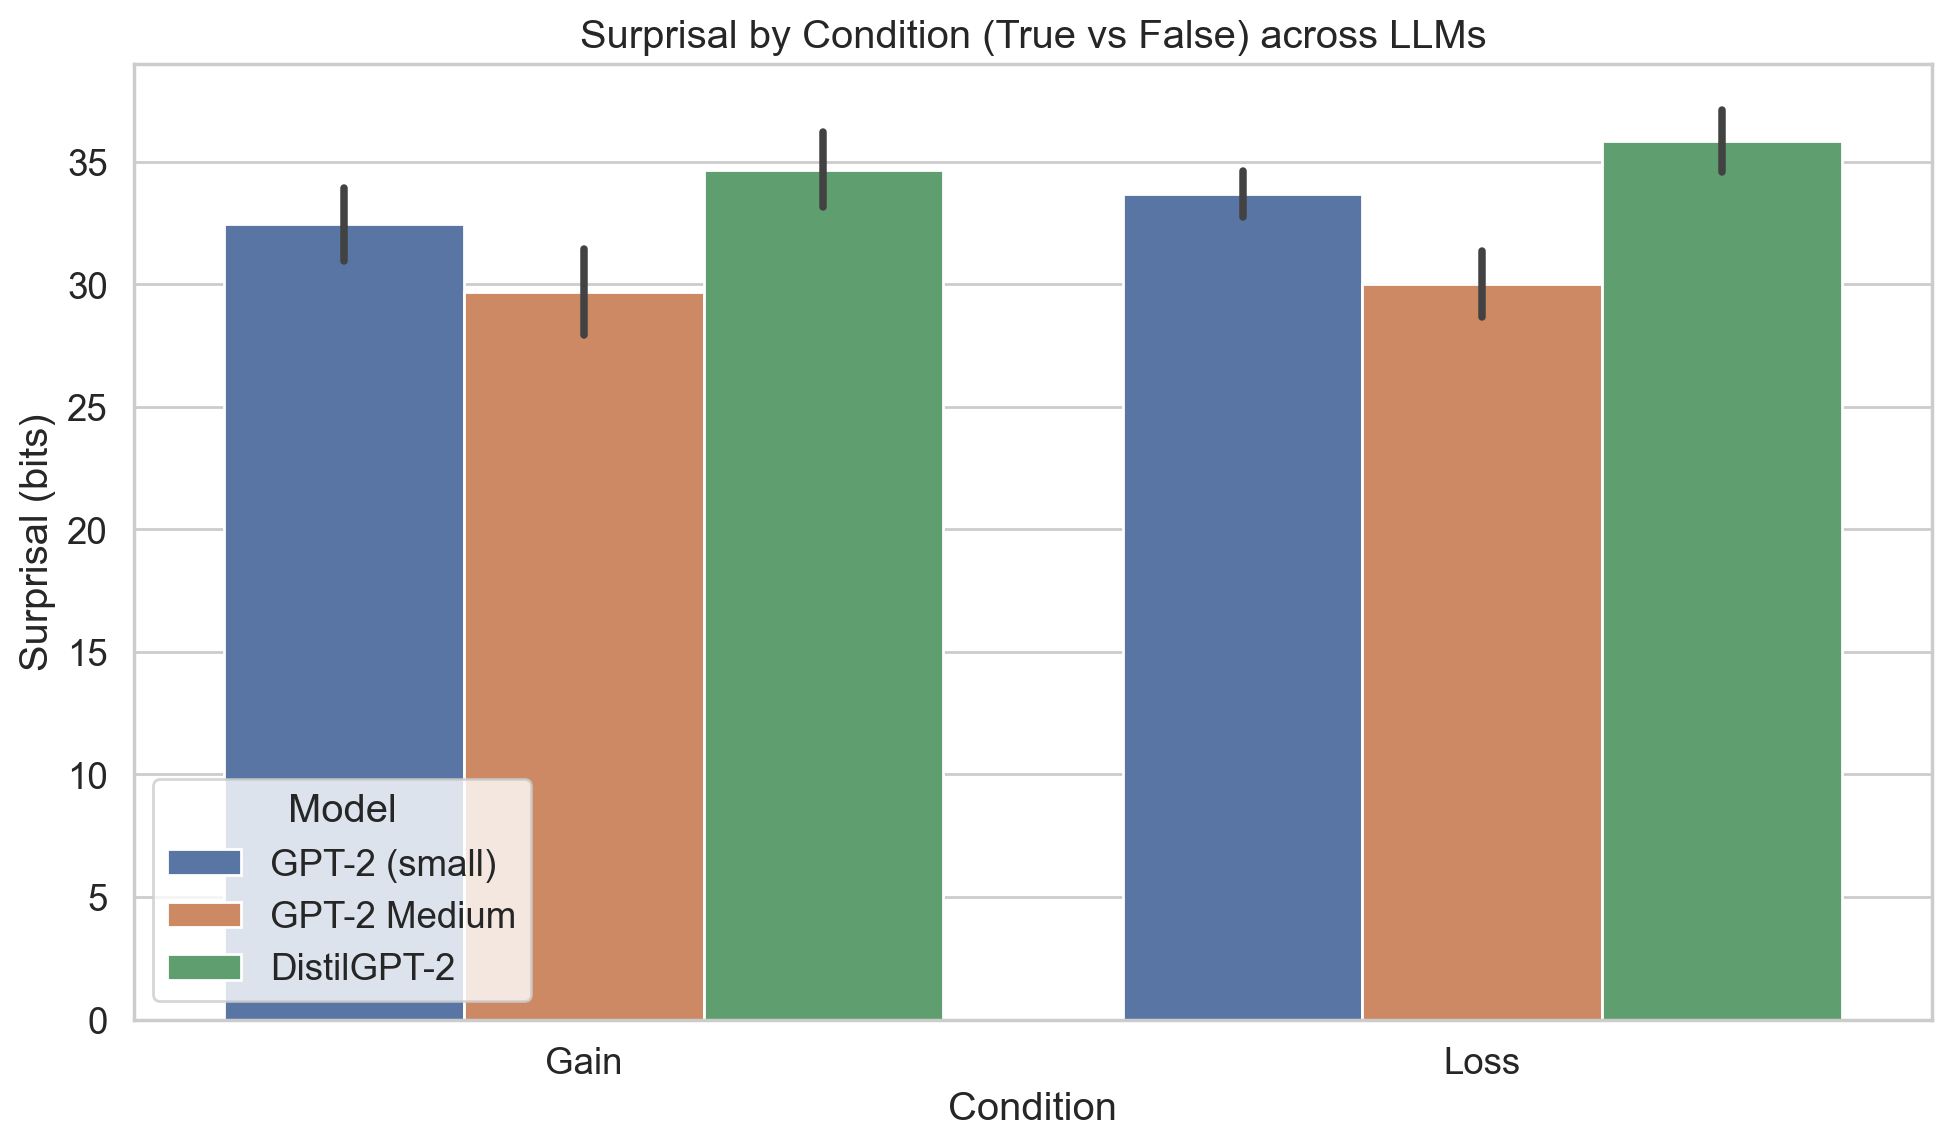

In [74]:
plt.figure(figsize=(10, 6))


sns.barplot(
    data=df_results,
    x="Condition",
    y="Surprisal",
    hue="Model_pretty",
    errorbar="se" 
)

plt.title("Surprisal by Condition (True vs False) across LLMs")
plt.ylabel("Surprisal (bits)")
plt.xlabel("Condition")

plt.legend(title="Model")
plt.tight_layout()
plt.show()

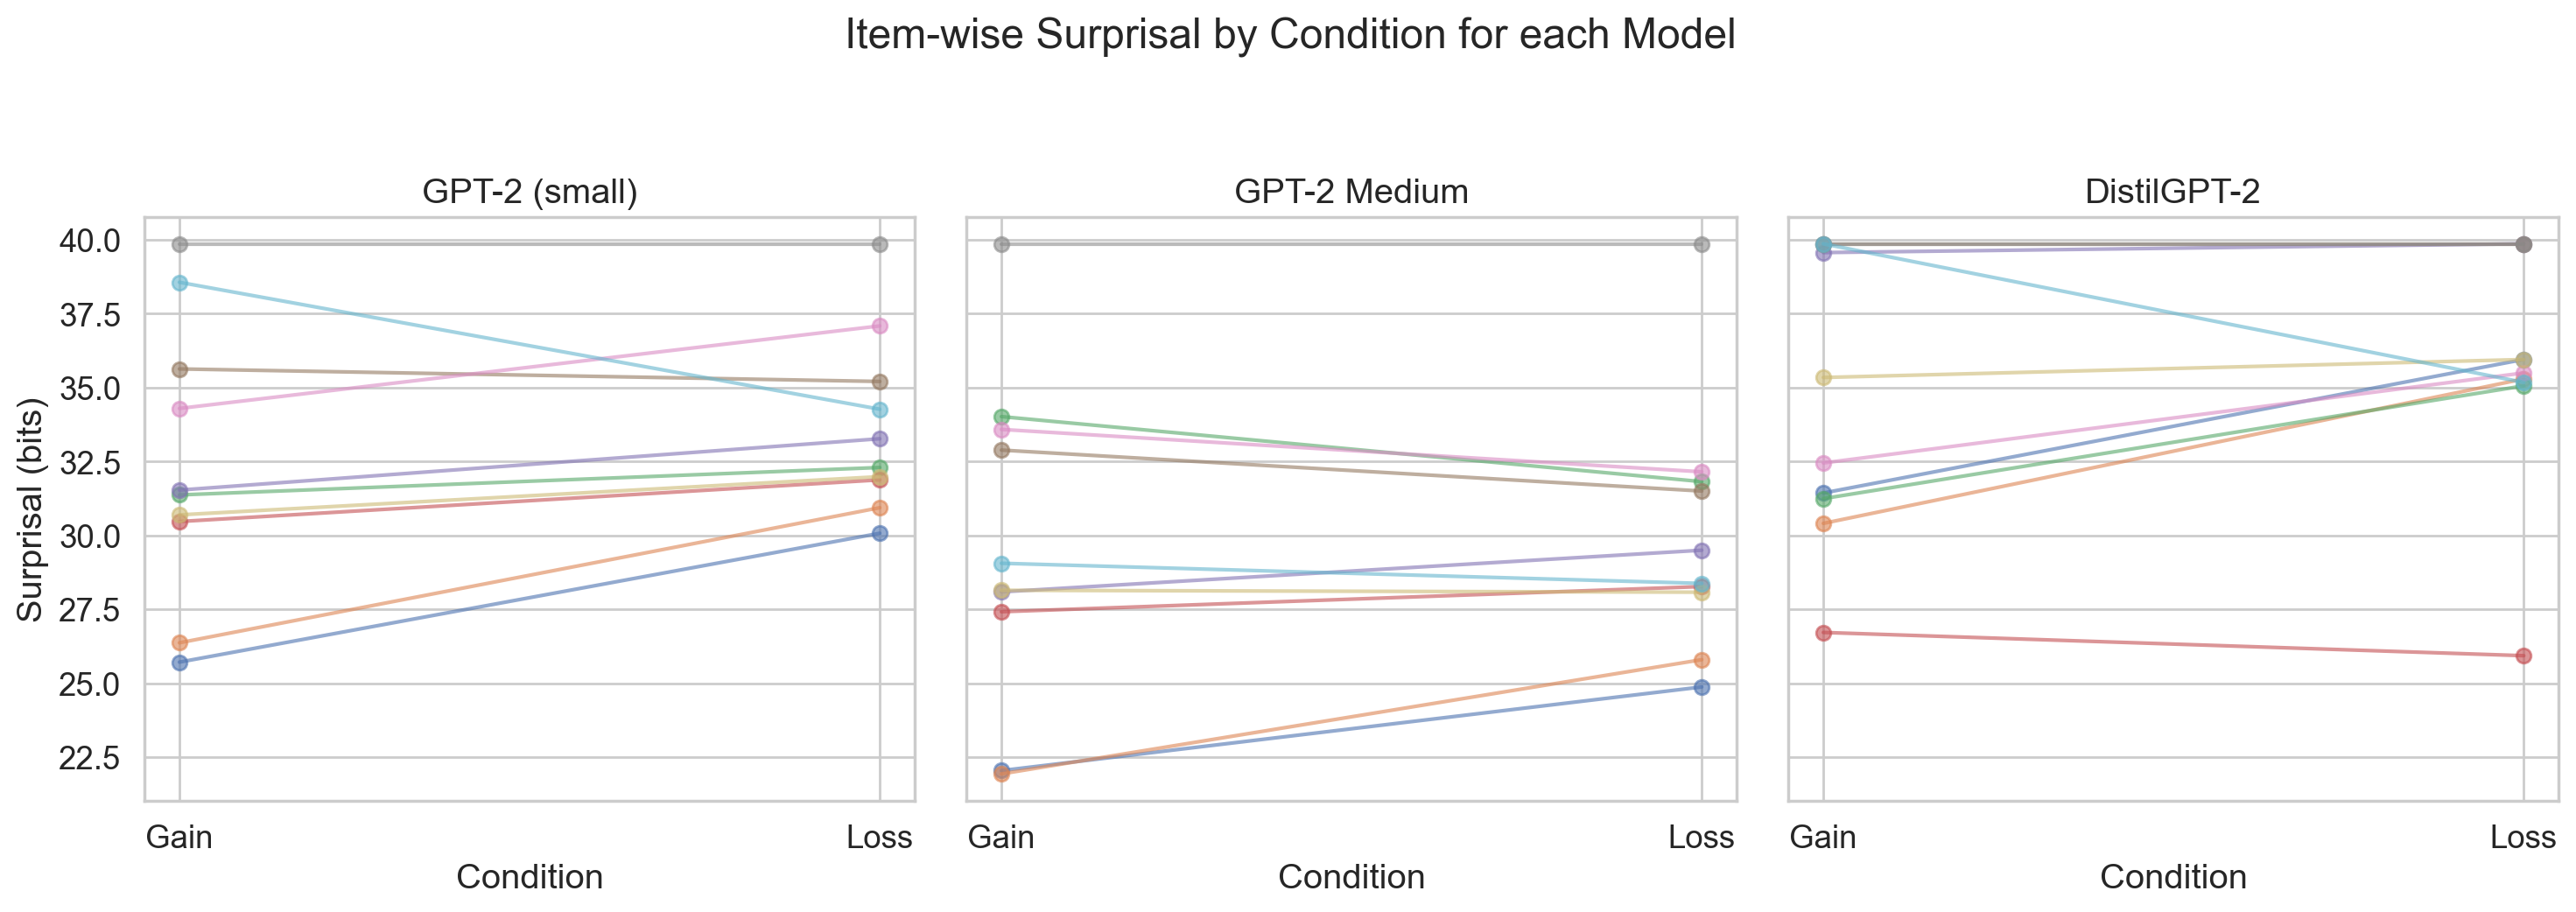

In [75]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)


for ax, model_name in zip(axes, df_results["Model_pretty"].unique()):


    sub = df_results[df_results["Model_pretty"] == model_name]

  
    for item_id in sub["Item"].unique():
        item_data = sub[sub["Item"] == item_id]

       
        item_data = item_data.sort_values("Condition")

        ax.plot(
            item_data["Condition"],     
            item_data["Surprisal"],      
            marker="o",
            alpha=0.6
        )

    ax.set_title(model_name)
    ax.set_xlabel("Condition")


axes[0].set_ylabel("Surprisal (bits)")


fig.suptitle("Item-wise Surprisal by Condition for each Model", y=1.05)

plt.tight_layout()
plt.show()


In [76]:
summary = (
    df_results
    .groupby(["Model_pretty", "Condition"])["Surprisal"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

print("\nSummary statistics (mean surprisal by model and condition):")
print(summary)



Summary statistics (mean surprisal by model and condition):
    Model_pretty Condition       mean       std  count
0    DistilGPT-2      Gain  34.673811  4.875948     10
1    DistilGPT-2      Loss  35.843630  4.059270     10
2  GPT-2 (small)      Gain  32.448049  4.682204     10
3  GPT-2 (small)      Loss  33.685191  3.004996     10
4   GPT-2 Medium      Gain  29.701840  5.546434     10
5   GPT-2 Medium      Loss  30.020697  4.230134     10
